<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Keys" data-toc-modified-id="Keys-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Keys</a></span></li><li><span><a href="#Prepping-read-count-data" data-toc-modified-id="Prepping-read-count-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepping read count data</a></span><ul class="toc-item"><li><span><a href="#Combining-unnormalized-raw-FeatureCounts-data" data-toc-modified-id="Combining-unnormalized-raw-FeatureCounts-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Combining unnormalized raw FeatureCounts data</a></span></li></ul></li><li><span><a href="#DESeq2" data-toc-modified-id="DESeq2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DESeq2</a></span><ul class="toc-item"><li><span><a href="#Installing-packages-and-loading-libraries" data-toc-modified-id="Installing-packages-and-loading-libraries-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Installing packages and loading libraries</a></span></li><li><span><a href="#DESeq2-normalizing-raw-data" data-toc-modified-id="DESeq2-normalizing-raw-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DESeq2 normalizing raw data</a></span></li><li><span><a href="#Generating-a-Pseudoreference" data-toc-modified-id="Generating-a-Pseudoreference-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generating a Pseudoreference</a></span></li><li><span><a href="#Unnormalized-MA-line-Read-Counts" data-toc-modified-id="Unnormalized-MA-line-Read-Counts-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Unnormalized MA line Read Counts</a></span></li><li><span><a href="#PCA-Plots" data-toc-modified-id="PCA-Plots-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>PCA Plots</a></span><ul class="toc-item"><li><span><a href="#PCA-with-Log2-Fold-Change-Values" data-toc-modified-id="PCA-with-Log2-Fold-Change-Values-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>PCA with Log<sub>2</sub> Fold Change Values</a></span></li></ul></li><li><span><a href="#DESeq2---Differential-Expression-Analysis" data-toc-modified-id="DESeq2---Differential-Expression-Analysis-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>DESeq2 - Differential Expression Analysis</a></span><ul class="toc-item"><li><span><a href="#Natural-Isolates-relative-to-Pseudo-reference" data-toc-modified-id="Natural-Isolates-relative-to-Pseudo-reference-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>Natural Isolates relative to Pseudo-reference</a></span></li></ul></li></ul></li><li><span><a href="#Natural-Isolates-&amp;-MA---Log2Fold-Change-and-DEGs" data-toc-modified-id="Natural-Isolates-&amp;-MA---Log2Fold-Change-and-DEGs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Natural Isolates &amp; MA - Log2Fold Change and DEGs</a></span></li></ul></div>

# Keys

In [1]:
import json
import pandas as pd
import numpy as np
from numpy import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import fligner
from scipy.stats import skewtest
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd
import sklearn
from sklearn.metrics import r2_score
import os
import statistics
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
%load_ext rpy2.ipython

# Prepping read count data

## Combining unnormalized raw FeatureCounts data

Natural Isolates

In [75]:
#### Names of gene count files ####
keyword = 'genes_count'
label1 = []
for fname in os.listdir('/research/projects/chlamydomonas/NIexpression/data/gene_count/NI_lines'):
    if keyword in fname:
        fname = fname.replace('_genes_count','')
        label1.append(fname)
        
#### Unnormalized gene counts ####
gene_count = pd.DataFrame()
for i in label1:
    section = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/gene_count/NI_lines/' + i + '_genes_count', delimiter = '\t', skiprows = 1)
    section.columns = ['geneid', 'chr', 'start', 'end', 'strand', 'length', i]
    section = section[['geneid', i]]
    gene_count = pd.concat([gene_count, section], axis = 1)

gene_count = gene_count.loc[:,~gene_count.columns.duplicated()]
gene_count['geneid'] = gene_count['geneid'].str.replace('_4532.v6.1', '')
gene_count = gene_count.set_index('geneid')

#### Renaming columns ####
col = pd.DataFrame(gene_count.columns)
for idx in col.index.values:
    if any(x in col.loc[idx, 0] for x in ['CC2344', 'CC2931', 'GB']):
        col.loc[idx, 0] = col.loc[idx, 0].split('.')[1]
gene_count.columns = col[0]

#### Exporting combined gene counts ####
gene_count.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI_raw.txt', sep = '\t', index = True, header = True)

<ipython-input-75-5a9554b7c43c>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  gene_count['geneid'] = gene_count['geneid'].str.replace('_4532.v6.1', '')


Mutation Accumulation Lines : CC-2344 & CC-2931

In [52]:
#### Names of gene count files ####
keyword = 'genes_count'
label1 = []
for fname in os.listdir('/research/projects/chlamydomonas/NIexpression/data/gene_count/MA_lines'):
    if keyword in fname:
        fname = fname.replace('_genes_count','')
        label1.append(fname)
        
#### Unnormalized gene counts ####
gene_count = pd.DataFrame()
for i in label1:
    section = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/gene_count/MA_lines/' + i + '_genes_count', delimiter = '\t', skiprows = 1)
    section.columns = ['geneid', 'chr', 'start', 'end', 'strand', 'length', i]
    section = section[['geneid', i]]
    gene_count = pd.concat([gene_count, section], axis = 1)

gene_count = gene_count.loc[:,~gene_count.columns.duplicated()]
gene_count['geneid'] = gene_count['geneid'].str.replace('_4532.v6.1', '')
gene_count = gene_count.set_index('geneid')

#### Renaming columns ####
gene_count.columns = pd.DataFrame(gene_count.columns)[0].str.split('.', expand = True)[1].str.replace('_', '-')

#### Exporting combined gene counts ####
gene_count.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_CC2344+CC2931_raw.txt', sep = '\t', index = True, header = True)

<ipython-input-52-4b40b3c8e992>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  gene_count['geneid'] = gene_count['geneid'].str.replace('_4532.v6.1', '')


# DESeq2

## Installing packages and loading libraries

In [2]:
%%R
## TIDYVERSE
library(tidyverse)

## DESEQ2
library("BiocParallel")
register(MulticoreParam(4))
library("DESeq2")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.fram

## DESeq2 normalizing raw data

In [27]:
%%R

##########################
#### Natural isolates ####
##########################
combined_raw_counts <- read.csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI_raw.txt', sep = '\t', header = TRUE, stringsAsFactors = FALSE, row.names = 'geneid')
counts <- combined_raw_counts[c(1:length(combined_raw_counts))]

#### Assigning factors and conditions ####
condition <- c('CC2344.ANC','CC2931.ANC', 'GB49', 'GB119', 'GB13', 'GB141', 'GB117', 'GB57', 'GB66', 'GB123', 'CL3', 
               'W13_1', 'W13_2', 'JG4', 'CC3063', 'CC3060', 'CC2932', 'CC3079', 'CC2343', 'CC2342', 
              'CC3059', 'BMS1', 'CC3061', 'CC1952')
factor <- colnames(counts)
columns <- factor
for (i in condition) {factor[grep((i), factor)] <- i}
coldata <- data.frame(factor, columns, row.names = 'columns')

#### Creating data object ####
combined_dds <- DESeqDataSetFromMatrix(countData = counts, colData = coldata, design = ~ factor)
directory <- "/research/projects/chlamydomonas/NIexpression/data/raw_counts/"
combined_dds <- estimateSizeFactors(combined_dds)
counts <- counts(combined_dds, normalized=TRUE)
write.table(counts, paste(directory, "NI_deseq_normalized", ".txt", sep=""), sep="\t", quote = F)

In [11]:
%%R

########################################################
#### Natural isolates + Mutation Accumulation Lines ####
########################################################
raw_counts <- read.csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI+MA+pseudoreference.txt', sep = '\t', header = TRUE, stringsAsFactors = FALSE, row.names = "geneid")
raw_counts <- subset(raw_counts, select = -c(pseudo.reference))
counts <- raw_counts[c(1:length(raw_counts))]

#### Assigning factors and conditions ####
condition <- c('CC2344.ANC','CC2931.ANC', 'GB49', 'GB119', 'GB13', 'GB141', 'GB117', 'GB57', 'GB66',
               'GB123', 'CL3', 'W13_1', 'W13_2', 'JG4', 'CC3063', 'CC3060', 'CC2932', 'CC3079', 'CC2343', 'CC2342',
               'CC3059', 'BMS1', 'CC3061', 'CC1952', "CC2344.L2", "CC2344.L3", "CC2344.L4",
               "CC2344.L5", "CC2344.L6", "CC2344.L7", "CC2344.L8", "CC2344.L9", "CC2344.L10", "CC2344.L11",
               "CC2344.L12", "CC2344.L13", "CC2344.L14", "CC2344.L15", "CC2931.L2", "CC2931.L3",
               "CC2931.L4", "CC2931.L5", "CC2931.L6", "CC2931.L7", "CC2931.L9", "CC2931.L10", "CC2931.L11", "CC2931.L13",
               "CC2931.L14", "CC2931.L15")
factor <- colnames(counts)
columns <- factor
for (i in condition) {factor[grep((i), factor)] <- i}
factor[grep('CC2344.L1.rep', factor)] <- 'CC2344.L1'
factor[grep('CC2931.L1.rep', factor)] <- 'CC2931.L1'
coldata <- data.frame(factor, columns, row.names = 'columns')

#### Creating data object ####
combined_dds <- DESeqDataSetFromMatrix(countData = counts, colData = coldata, design = ~ factor)
directory <- "/research/projects/chlamydomonas/NIexpression/data/raw_counts/"
combined_dds <- estimateSizeFactors(combined_dds)
counts <- counts(combined_dds, normalized=TRUE)
write.table(counts, paste(directory, "NI+MA_deseq_normalized", ".txt", sep=""), sep="\t", quote = F)

## Generating a Pseudoreference

In [12]:
NI = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI_raw.txt', delimiter = '\t', index_col = 'geneid')
MA = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_CC2344+CC2931_raw.txt', delimiter = '\t', index_col = 'geneid')
combined = pd.concat([NI, MA], axis = 1)
combined.astype(int) ## Change values in dataframe from a string to an integer
combined = combined + 1 ## Adding one to every value given the presence of 0s affect geometric mean
combined['pseudo-reference'] = scipy.stats.gmean(combined, axis=1) ## Creating a pseudo-reference by taking the geometric mean
combined['pseudo-reference'] = combined['pseudo-reference'].astype(int)
combined.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI+MA+pseudoreference.txt', sep = '\t', index = True, header = True)

#### Pseudoreference made using normalized lines ####
combined = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/NI+MA_deseq_normalized.txt', delimiter = '\t')
combined.astype(int) ## Change values in dataframe from a string to an integer
combined = combined + 1 ## Adding one to every value given the presence of 0s affect geometric mean
combined['pseudo-reference'] = scipy.stats.gmean(combined, axis=1) ## Creating a pseudo-reference by taking the geometric mean
combined['pseudo-reference'] = combined['pseudo-reference'].astype(int)
combined.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/deseq_normalized_NI+MA+pseudoreference.txt', sep = '\t', index = True, header = True)

## Unnormalized MA line Read Counts

In [33]:
combined = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI+MA+pseudoreference.txt', delimiter = '\t', index_col = 'geneid')
col = pd.DataFrame(combined.columns)[combined.columns.str.contains('CC2931')][0]
unnormalized_CC2931 = combined[col]
unnormalized_CC2931.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_CC2931_raw.txt', sep = '\t', index = True, header = True)

col = pd.DataFrame(combined.columns)[combined.columns.str.contains('CC2344')][0]
unnormalized_CC2344 = combined[col]
unnormalized_CC2344.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_CC2344_raw.txt', sep = '\t', index = True, header = True)

## PCA Plots 

In [3]:
%%R
library(mixOmics)
library(tidyverse)
library(WGCNA)

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Loading required package: lattice

R[write to console]: 
Loaded mixOmics 6.14.1
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')


R[write to console]: 
Attaching package: ‘mixOmics’


R[write to console]: The following object is masked from ‘package:purrr’:

    map


R[write to console]: Loading required package: dynamicTreeCut

R[write to console]: Loading required package: fastcluster

R[write to console]: 
Attaching package: ‘fastcluster’


R[write to console]: The following object is masked from ‘package:stats’:

    hclust


R[write to console]: 

R[write to console]: 
Attaching package: ‘WGCNA’


R[

### PCA with Log<sub>2</sub> Fold Change Values

In [4]:
%%R
NA1 <- c('CC3063', 'CC3061', 'CC3059', 'CC3060', 'GB119', 'GB141', 'GB66', 'GB123', 'GB13', 'GB117', 'GB49', 'GB57', 'W13_1', 'W13_2')
NA2 <- c('CC2344', 'CC2931', 'CC3079', 'CC2343', 'CC1952', 'CC2342', 'CC2932', 'CL3', 'BMS1', 'JG4')

expression.data <- read.delim('/research/projects/chlamydomonas/NIexpression/data/raw_counts/NI_l2f', header = T, row.names = 'X')
expression.data <- t(expression.data)

substructure <- rownames(expression.data)
columns <- substructure
for (i in NA1) {substructure[grep((i), substructure)] <- 'NA1'}
for (i in NA2) {substructure[grep((i), substructure)] <- 'NA2'}
rowdata <- data.frame(substructure, row.names = columns)

## Filtering through the dataframe for missing values per gene ##
gsg <- goodSamplesGenes(expression.data, verbose = 5)
gsg$allOK
if (!gsg$allOK)
{
 expression.data <- expression.data[gsg$goodSamples, gsg$goodGenes]
}

norm.expr.df <- expression.data
tuning <- tune.pca(norm.expr.df, center=TRUE, scale=TRUE)
pca.result <- pca(norm.expr.df, ncomp=10, center=T, scale=T)
pca.result$substructure <- substructure

pdf("/research/projects/chlamydomonas/NIexpression/data/plots/PCA_NIexpressiondata.pdf", width = 8, height = 4)
plotIndiv(pca.result, comp=c(1,2), group = rowdata$substructure, legend = TRUE)

 Flagging genes and samples with too many missing values...
  ..step 1


In [51]:
%%R
pca.result

  Eigenvalues for the first 2 principal components, see object$sdev^2: 
      PC1       PC2 
1.4409564 0.5590436 
  
  Proportion of  explained variance for the first 2 principal components, see object$prop_expl_var: 
      PC1            PC2      
0.7204782      0.2795218      
  
  Cumulative proportion of  explained variance for the first 2 principal components, see object$cum.var: 
      PC1            PC2      
0.7204782      1.0000000      
  
  Other available components: 
 -------------------- 
  loading vectors: see object$rotation 
  Other functions: 
 -------------------- 
  plotIndiv, plot, plotVar, selectVar, biplot


 Flagging genes and samples with too many missing values...
  ..step 1


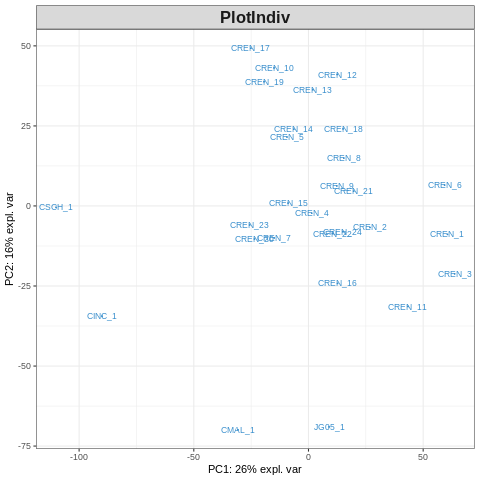

In [11]:
%%R
expression.data <- read.delim('/research/projects/chlamydomonas/NIexpression/data/expression_divergence/EVE_expression_data_TPM2.csv', header = T, row.names = "index")
expression.data <- t(expression.data)

## Filtering through the dataframe for missing values per gene ##
gsg <- goodSamplesGenes(expression.data, verbose = 5)
gsg$allOK
if (!gsg$allOK)
{
 expression.data <- expression.data[gsg$goodSamples, gsg$goodGenes]
}

norm.expr.df <- expression.data
tuning <- tune.pca(norm.expr.df, center=TRUE, scale=TRUE)
pca.result <- pca(norm.expr.df, ncomp=20, center=T, scale=T)
plotIndiv(pca.result, comp=c(1,2))

 Flagging genes and samples with too many missing values...
  ..step 1


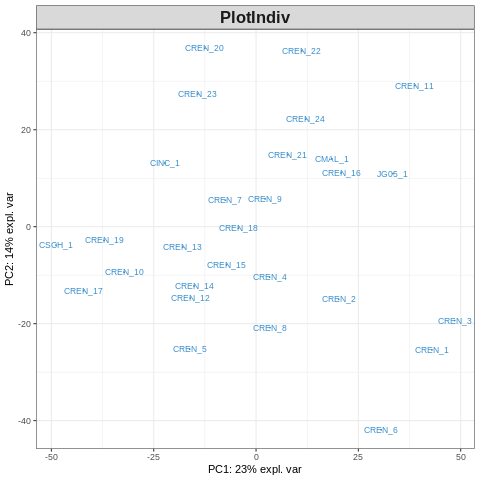

In [4]:
%%R
expression.data <- read.delim('/research/projects/chlamydomonas/NIexpression/data/expression_divergence/EVE_abnormalcluster2.csv', header = T, row.names = "index")
expression.data <- t(expression.data)

## Filtering through the dataframe for missing values per gene ##
gsg <- goodSamplesGenes(expression.data, verbose = 5)
gsg$allOK
if (!gsg$allOK)
{
 expression.data <- expression.data[gsg$goodSamples, gsg$goodGenes]
}

norm.expr.df <- expression.data
tuning <- tune.pca(norm.expr.df, center=TRUE, scale=TRUE)
pca.result <- pca(norm.expr.df, ncomp=20, center=T, scale=T)
plotIndiv(pca.result, comp=c(1,2))

 Flagging genes and samples with too many missing values...
  ..step 1


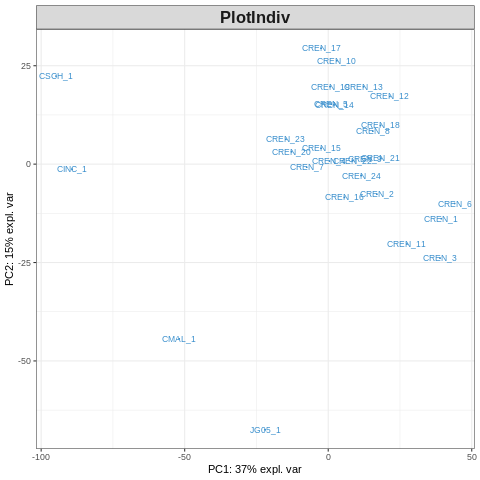

In [9]:
%%R
expression.data <- read.delim('/research/projects/chlamydomonas/NIexpression/data/expression_divergence/EVE_normalcluster2.csv', header = T, row.names = "X")
expression.data <- t(expression.data)

## Filtering through the dataframe for missing values per gene ##
gsg <- goodSamplesGenes(expression.data, verbose = 5)
gsg$allOK
if (!gsg$allOK)
{
 expression.data <- expression.data[gsg$goodSamples, gsg$goodGenes]
}

norm.expr.df <- expression.data
tuning <- tune.pca(norm.expr.df, center=TRUE, scale=TRUE)
pca.result <- pca(norm.expr.df, ncomp=20, center=T, scale=T)
plotIndiv(pca.result, comp=c(1,2))

In [12]:
%%R
pca.result

  Eigenvalues for the first 10 principal components, see object$sdev^2: 
      PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8 
1467.7165  892.5204  558.1294  443.1787  294.9596  232.7140  194.0787  171.8473 
      PC9      PC10 
 157.3036  130.2726 
  
  Proportion of  explained variance for the first 10 principal components, see object$prop_expl_var: 
       PC1             PC2             PC3             PC4             PC5      
0.25731356      0.15647273      0.09784877      0.07769613      0.05171101      
       PC6             PC7             PC8             PC9            PC10      
0.04079839      0.03402502      0.03012750      0.02757776      0.02283882      
  
  Cumulative proportion of  explained variance for the first 10 principal components, see object$cum.var: 
      PC1            PC2            PC3            PC4            PC5      
0.2573136      0.4137863      0.5116350      0.5893312      0.6410422      
      PC6            PC7        

## DESeq2 - Differential Expression Analysis

### Natural Isolates relative to Pseudo-reference

Creating DESeq2 data object

In [18]:
%%R

raw_counts <- read.csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/unnormalized_NI+MA+pseudoreference.txt', sep = '\t', header = TRUE, stringsAsFactors = FALSE, row.names = "geneid")
counts <- raw_counts[c(1:length(raw_counts))]

#### Assigning factors and conditions ####
condition <- c('pseudo.reference', 'CC2344.ANC','CC2931.ANC', 'GB49', 'GB119', 'GB13', 'GB141', 'GB117', 'GB57', 'GB66',
               'GB123', 'CL3', 'W13_1', 'W13_2', 'JG4', 'CC3063', 'CC3060', 'CC2932', 'CC3079', 'CC2343', 'CC2342',
               'CC3059', 'BMS1', 'CC3061', 'CC1952', "CC2344.L2", "CC2344.L3", "CC2344.L4",
               "CC2344.L5", "CC2344.L6", "CC2344.L7", "CC2344.L8", "CC2344.L9", "CC2344.L10", "CC2344.L11",
               "CC2344.L12", "CC2344.L13", "CC2344.L14", "CC2344.L15", "CC2931.L2", "CC2931.L3",
               "CC2931.L4", "CC2931.L5", "CC2931.L6", "CC2931.L7", "CC2931.L9", "CC2931.L10", "CC2931.L11", "CC2931.L13",
               "CC2931.L14", "CC2931.L15")
factor <- colnames(counts)
columns <- factor
for (i in condition) {factor[grep((i), factor)] <- i}
factor[grep('CC2344.L1.rep', factor)] <- 'CC2344.L1'
factor[grep('CC2931.L1.rep', factor)] <- 'CC2931.L1'
coldata <- data.frame(factor, columns, row.names = 'columns')

#### Creating data object ####
dds1 <- DESeqDataSetFromMatrix(countData = counts, colData = coldata, design = ~ factor)

Running DESeq2

In [20]:
%%R

#### USING DESEQ2 #####
dds <- DESeq(dds1, parallel = TRUE)

## Natural Isolates ##
res_GB117 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB117', 'pseudo.reference'), alpha = 0.05)
res_GB119 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB119', 'pseudo.reference'), alpha = 0.05)
res_GB49 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB49', 'pseudo.reference'), alpha = 0.05)
res_GB141 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB141', 'pseudo.reference'), alpha = 0.05)
res_GB66 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB66', 'pseudo.reference'), alpha = 0.05)
res_GB57 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB57', 'pseudo.reference'), alpha = 0.05)
res_GB13 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB13', 'pseudo.reference'), alpha = 0.05)
res_GB123 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'GB123', 'pseudo.reference'), alpha = 0.05)
res_CC2344 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.ANC', 'pseudo.reference'), alpha = 0.05)
res_CC2931 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.ANC', 'pseudo.reference'), alpha = 0.05)
res_CL3 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CL3', 'pseudo.reference'), alpha = 0.05)
res_W13_1 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'W13_1', 'pseudo.reference'), alpha = 0.05)
res_W13_2 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'W13_2', 'pseudo.reference'), alpha = 0.05)
res_JG4 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'JG4', 'pseudo.reference'), alpha = 0.05)
res_BMS1 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'BMS1', 'pseudo.reference'), alpha = 0.05)
res_CC3063 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC3063', 'pseudo.reference'), alpha = 0.05)
res_CC3060 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC3060', 'pseudo.reference'), alpha = 0.05)
res_CC3061 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC3061', 'pseudo.reference'), alpha = 0.05)
res_CC2932 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2932', 'pseudo.reference'), alpha = 0.05)
res_CC3079 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC3079', 'pseudo.reference'), alpha = 0.05)
res_CC3059 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC3059', 'pseudo.reference'), alpha = 0.05)
res_CC1952 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC1952', 'pseudo.reference'), alpha = 0.05)
res_CC2343 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2343', 'pseudo.reference'), alpha = 0.05)
res_CC2342 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2342', 'pseudo.reference'), alpha = 0.05)

## Mutation Accumulation Lines ##
res_CC2344_L1 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L1', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L2 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L2', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L3 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L3', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L4 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L4', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L5 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L5', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L6 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L6', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L7 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L7', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L8 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L8', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L9 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L9', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L10 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L10', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L11 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L11', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L12 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L12', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L13 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L13', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L14 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L14', 'pseudo.reference'), alpha = 0.05)
res_CC2344_L15 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2344.L15', 'pseudo.reference'), alpha = 0.05)

res_CC2931_L1 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L1', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L2 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L2', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L3 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L3', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L4 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L4', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L5 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L5', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L6 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L6', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L7 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L7', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L9 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L9', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L10 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L10', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L11 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L11', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L13 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L13', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L14 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L14', 'pseudo.reference'), alpha = 0.05)
res_CC2931_L15 <- results(dds, pAdjustMethod = "BH", contrast = c('factor', 'CC2931.L15', 'pseudo.reference'), alpha = 0.05)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



In [23]:
%%R
#### FILES OF DIFFERNTIALLY EXPRESSED GENES ####

## Natural Isolates ##
resSig_GB117 = res_GB117[which(res_GB117$padj < 0.05),]
resSig_GB119 = res_GB119[which(res_GB119$padj < 0.05),]
resSig_GB49 = res_GB49[which(res_GB49$padj < 0.05),]
resSig_GB141 = res_GB141[which(res_GB141$padj < 0.05),]
resSig_GB66 = res_GB66[which(res_GB66$padj < 0.05),]
resSig_GB57 = res_GB57[which(res_GB57$padj < 0.05),]
resSig_GB13 = res_GB13[which(res_GB13$padj < 0.05),]
resSig_GB123 = res_GB123[which(res_GB123$padj < 0.05),]
resSig_CC2344 = res_CC2344[which(res_CC2344$padj < 0.05),]
resSig_CC2931 = res_CC2931[which(res_CC2931$padj < 0.05),]
resSig_CL3 = res_CL3[which(res_CL3$padj < 0.05),]
resSig_W13_1 = res_W13_1[which(res_W13_1$padj < 0.05),]
resSig_W13_2 = res_W13_2[which(res_W13_2$padj < 0.05),]
resSig_JG4 = res_JG4[which(res_JG4$padj < 0.05),]
resSig_BMS1 = res_BMS1[which(res_BMS1$padj < 0.05),]
resSig_CC3063 = res_CC3063[which(res_CC3063$padj < 0.05),]
resSig_CC3060 = res_CC3060[which(res_CC3060$padj < 0.05),]
resSig_CC3061 = res_CC3061[which(res_CC3061$padj < 0.05),]
resSig_CC2932 = res_CC2932[which(res_CC2932$padj < 0.05),]
resSig_CC3079 = res_CC3079[which(res_CC3079$padj < 0.05),]
resSig_CC3059 = res_CC3059[which(res_CC3059$padj < 0.05),]
resSig_CC1952 = res_CC1952[which(res_CC1952$padj < 0.05),]
resSig_CC2343 = res_CC2343[which(res_CC2343$padj < 0.05),]
resSig_CC2342 = res_CC2342[which(res_CC2342$padj < 0.05),]

## Mutation Accumulation lines ##
resSig_CC2344_L1 = res_CC2344_L1[which(res_CC2344_L1$padj < 0.05),]
resSig_CC2344_L2 = res_CC2344_L2[which(res_CC2344_L2$padj < 0.05),]
resSig_CC2344_L3 = res_CC2344_L3[which(res_CC2344_L3$padj < 0.05),]
resSig_CC2344_L4 = res_CC2344_L4[which(res_CC2344_L4$padj < 0.05),]
resSig_CC2344_L5 = res_CC2344_L5[which(res_CC2344_L5$padj < 0.05),]
resSig_CC2344_L6 = res_CC2344_L6[which(res_CC2344_L6$padj < 0.05),]
resSig_CC2344_L7 = res_CC2344_L7[which(res_CC2344_L7$padj < 0.05),]
resSig_CC2344_L8 = res_CC2344_L8[which(res_CC2344_L8$padj < 0.05),]
resSig_CC2344_L9 = res_CC2344_L9[which(res_CC2344_L9$padj < 0.05),]
resSig_CC2344_L10 = res_CC2344_L10[which(res_CC2344_L10$padj < 0.05),]
resSig_CC2344_L11 = res_CC2344_L11[which(res_CC2344_L11$padj < 0.05),]
resSig_CC2344_L12 = res_CC2344_L12[which(res_CC2344_L12$padj < 0.05),]
resSig_CC2344_L13 = res_CC2344_L13[which(res_CC2344_L13$padj < 0.05),]
resSig_CC2344_L14 = res_CC2344_L14[which(res_CC2344_L14$padj < 0.05),]
resSig_CC2344_L15 = res_CC2344_L15[which(res_CC2344_L15$padj < 0.05),]

resSig_CC2931_L1 = res_CC2931_L1[which(res_CC2931_L1$padj < 0.05),]
resSig_CC2931_L2 = res_CC2931_L2[which(res_CC2931_L2$padj < 0.05),]
resSig_CC2931_L3 = res_CC2931_L3[which(res_CC2931_L3$padj < 0.05),]
resSig_CC2931_L4 = res_CC2931_L4[which(res_CC2931_L4$padj < 0.05),]
resSig_CC2931_L5 = res_CC2931_L5[which(res_CC2931_L5$padj < 0.05),]
resSig_CC2931_L6 = res_CC2931_L6[which(res_CC2931_L6$padj < 0.05),]
resSig_CC2931_L7 = res_CC2931_L7[which(res_CC2931_L7$padj < 0.05),]
resSig_CC2931_L9 = res_CC2931_L9[which(res_CC2931_L9$padj < 0.05),]
resSig_CC2931_L10 = res_CC2931_L10[which(res_CC2931_L10$padj < 0.05),]
resSig_CC2931_L11 = res_CC2931_L11[which(res_CC2931_L11$padj < 0.05),]
resSig_CC2931_L13 = res_CC2931_L13[which(res_CC2931_L13$padj < 0.05),]
resSig_CC2931_L14 = res_CC2931_L14[which(res_CC2931_L14$padj < 0.05),]
resSig_CC2931_L15 = res_CC2931_L15[which(res_CC2931_L15$padj < 0.05),]

In [24]:
%%R
#### EXPORTING FILES OF DIFFERNTIALLY EXPRESSED GENES ####
write.csv(as.data.frame(resSig_GB117), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB117_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB119), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB119_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB49), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB49_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB141), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB141_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB66), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB66_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB57), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB57_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB13), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB13_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_GB123), file="/research/projects/chlamydomonas/NIexpression/data/degs/GB123_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CL3), file="/research/projects/chlamydomonas/NIexpression/data/degs/CL3_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_W13_1), file="/research/projects/chlamydomonas/NIexpression/data/degs/W13_1_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_W13_2), file="/research/projects/chlamydomonas/NIexpression/data/degs/W13_2_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_JG4), file="/research/projects/chlamydomonas/NIexpression/data/degs/JG4_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_BMS1), file="/research/projects/chlamydomonas/NIexpression/data/degs/BMS1_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC3063), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC3063_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC3060), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC3060_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC3061), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC3061_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2932), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2932_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC3079), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC3079_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC3059), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC3059_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC1952), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC1952_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2343), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2343_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2342), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2342_vs_pseudoreference.genes")

write.csv(as.data.frame(resSig_CC2344_L1), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L1_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L2), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L2_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L3), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L3_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L4), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L4_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L5), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L5_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L6), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L6_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L7), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L7_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L8), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L8_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L9), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L9_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L10), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L10_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L11), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L11_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L12), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L12_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L13), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L13_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L14), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L14_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2344_L15), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2344_L15_vs_pseudoreference.genes")

write.csv(as.data.frame(resSig_CC2931_L1), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L1_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L2), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L2_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L3), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L3_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L4), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L4_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L5), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L5_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L6), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L6_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L7), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L7_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L9), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L9_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L10), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L10_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L11), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L11_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L13), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L13_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L14), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L14_vs_pseudoreference.genes")
write.csv(as.data.frame(resSig_CC2931_L15), file="/research/projects/chlamydomonas/NIexpression/data/degs/CC2931_L15_vs_pseudoreference.genes")

#### EXPORTING LOG2FOLD CHANGE RESULTS ####
write.table(as.data.frame(res_GB117), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB117_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB119), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB119_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB49), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB49_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB141), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB141_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB66), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB66_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB57), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB57_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB13), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB13_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_GB123), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/GB123_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CL3), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CL3_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_W13_1), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/W13_1_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_W13_2), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/W13_2_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_JG4), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/JG4_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_BMS1), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/BMS1_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC3063), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC3063_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC3060), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC3060_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC3061), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC3061_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2932), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2932_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC3079), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC3079_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC3059), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC3059_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC1952), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC1952_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2343), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2343_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2342), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2342_vs_pseudoreference',  sep="\t", quote = F)

write.table(as.data.frame(res_CC2344_L1), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L1_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L2), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L2_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L3), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L3_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L4), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L4_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L5), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L5_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L6), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L6_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L7), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L7_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L8), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L8_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L9), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L9_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L10), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L10_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L11), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L11_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L12), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L12_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L13), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L13_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L14), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L14_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2344_L15), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2344_L15_vs_pseudoreference',  sep="\t", quote = F)

write.table(as.data.frame(res_CC2931_L1), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L1_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L2), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L2_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L3), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L3_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L4), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L4_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L5), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L5_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L6), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L6_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L7), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L7_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L9), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L9_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L10), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L10_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L11), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L11_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L13), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L13_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L14), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L14_vs_pseudoreference',  sep="\t", quote = F)
write.table(as.data.frame(res_CC2931_L15), '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/CC2931_L15_vs_pseudoreference',  sep="\t", quote = F)

# Natural Isolates & MA - Log2Fold Change and DEGs

In [16]:
for i in ['NI_MA_l2f', 'total_degs']:
    exec('{} = pd.DataFrame()'.format(i))
    
keyword = 'pseudoreference'
for fname in os.listdir('/research/projects/chlamydomonas/NIexpression/data/genes_log2fold'):
    if keyword in fname:
        sample = fname.replace('_vs_pseudoreference','')
        NI_MA_l2f[sample] = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/' + fname, delimiter = "\t")['log2FoldChange']
    
for fname in os.listdir('/research/projects/chlamydomonas/NIexpression/data/degs'):
    if keyword in fname:
        sample = fname.replace('_vs_pseudoreference.genes','')
        total_degs[sample] = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/degs/' + fname)['Unnamed: 0']

total_degs.to_csv('/research/projects/chlamydomonas/NIexpression/data/degs/total_genes_NI+MA.csv', sep = '\t', header = True)
NI_MA_l2f.to_csv('/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/NI+MA_l2f.csv', sep = '\t', index = True, header = True)

,CC2931_L9,CC2931_L10,CC2931_L13,CC2931_L15,GB117,GB119,GB49,GB141,GB66,GB57,...,CC2344_L15,CC2931_L1,CC2931_L2,CC2931_L3,CC2931_L4,CC2931_L5,CC2931_L6,CC2931_L7,CC2931_L11,CC2931_L14
0,Cre01.g800043,Cre01.g800043,Cre01.g800031,Cre01.g800002,Cre01.g000500,Cre01.g009000,Cre01.g004700,Cre01.g009000,Cre01.g003463,Cre01.g000200,...,Cre01.g000350,Cre01.g800007,Cre01.g012350,Cre01.g800043,Cre01.g800043,Cre01.g800007,Cre01.g020701,Cre01.g800007,Cre01.g800043,Cre01.g007000
1,Cre01.g013500,Cre01.g013500,Cre01.g800043,Cre01.g800007,Cre01.g000850,Cre01.g009500,Cre01.g005750,Cre01.g800032,Cre01.g003475,Cre01.g001550,...,Cre01.g002227,Cre01.g005651,Cre01.g800043,Cre01.g013500,Cre01.g013500,Cre01.g015750,Cre01.g020750,Cre01.g800031,Cre01.g013500,Cre01.g013500
2,Cre01.g013550,Cre01.g020750,Cre01.g013500,Cre01.g005200,Cre01.g001200,Cre01.g014900,Cre01.g800030,Cre01.g800053,Cre01.g004651,Cre01.g002100,...,Cre01.g003650,Cre01.g800043,Cre01.g013500,Cre01.g015750,Cre01.g013900,Cre01.g020750,Cre01.g022500,Cre01.g800043,Cre01.g015750,Cre01.g014850
3,Cre01.g015750,Cre01.g022950,Cre01.g013550,Cre01.g005651,Cre01.g003650,Cre01.g015150,Cre01.g009765,Cre01.g016700,Cre01.g004900,Cre01.g002650,...,Cre01.g005200,Cre01.g013500,Cre01.g800048,Cre01.g020750,Cre01.g015750,Cre01.g023913,Cre01.g023913,Cre01.g013500,Cre01.g020750,Cre01.g014900
4,Cre01.g020750,Cre01.g023913,Cre01.g800049,Cre01.g008950,Cre28.g757547,Cre01.g800053,Cre01.g013000,Cre01.g800058,Cre01.g005400,Cre01.g003300,...,Cre01.g008150,Cre01.g016100,Cre01.g015650,Cre01.g022050,Cre01.g020750,Cre01.g028650,Cre01.g800072,Cre01.g013550,Cre01.g022950,Cre01.g014950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,Cre17.g802149,NaN,Cre16.g691500,Cre16.g681350,Cre08.g366900,Cre16.g801951,Cre12.g801348,Cre15.g801749,Cre07.g345050,Cre07.g331600,...,NaN,NaN,NaN,NaN,Cre15.g801832,NaN,NaN,Cre16.g801966,NaN,Cre13.g582050
338,Cre17.g745797,NaN,Cre16.g691450,Cre16.g801975,Cre08.g369683,Cre16.g669800,Cre12.g492150,Cre02.g142326,Cre07.g346317,Cre07.g332400,...,NaN,NaN,NaN,NaN,Cre02.g141406,NaN,NaN,Cre16.g682200,NaN,Cre13.g582112
339,Cre19.g802158,NaN,Cre16.g647800,Cre16.g681200,Cre08.g371200,Cre16.g669250,Cre12.g801359,Cre02.g142607,Cre07.g800852,Cre07.g800799,...,NaN,NaN,NaN,NaN,Cre17.g734548,NaN,NaN,Cre16.g681350,NaN,Cre13.g582150
340,CreCp.g802313,NaN,Cre16.g647950,Cre16.g801977,Cre08.g371840,Cre16.g681250,Cre12.g491600,Cre22.g754197,Cre07.g350700,Cre07.g334400,...,NaN,NaN,NaN,NaN,Cre17.g734400,NaN,NaN,Cre16.g801974,NaN,Cre13.g582900
